> # Facial Expression Recognition



# Intro
<p style='font-size:18px'>
The objective of this project is to develop Automatic Facial Expression Recognition System which can take human facial images containing some expression as input and recognize and classify it into seven different expression class such as  

1. Neutral  

2. Angry  

3. Disgust  

4. Fear  

5. Happy  

6. Sadness  

7. Surprise 
</p>

# Libraries
<p style='font-size:18px'>We load some standard libraries and packages of sklearn and Tensorflow. </p>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.utils import to_categorical

# Dataset and Load Data
<p style='font-size:18px'>We trained and tested our models on the data set from the Kaggle Facial Expression Recognition Challenge, which comprises 48-by-48-pixel grayscale images of human faces, each labeled with one of 7 emotion categories: anger, disgust, fear, happiness, sadness, surprise, and neutral. We used a training set of 28,709 examples, a validation set of 3,589 examples, and a test set of 3,589 examples.</p>

In [44]:
dataset_path = "dataset/csvs"
csvs = os.listdir(dataset_path)
sorted(csvs)

['icml_face_data_1.csv',
 'icml_face_data_2.csv',
 'icml_face_data_3.csv',
 'icml_face_data_4.csv',
 'icml_face_data_5.csv',
 'icml_face_data_6.csv']

In [46]:
li = []
for csv_file in sorted(csvs):
    li.append(pd.read_csv(os.path.join(dataset_path, csv_file)))

data = pd.concat(li, axis=0, ignore_index=True)
data.head()

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# Functions
<p style='font-size:18px'> We define some helper functions for preparing and ploting the data. </p>

In [47]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [48]:
data['usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: usage, dtype: int64

# Prepare Data
<p style='font-size:18px'> preparing data for Model </p>

In [49]:
emotions = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

<p style='font-size:18px'> Defining training, validation and test dataset </p>

In [50]:
train_data = data[data['usage']=='Training']
val_data = data[data['usage']=='PrivateTest']
test_data = data[data['usage']=='PublicTest']


train_img, train_img_label = prepare_data(train_data)
val_img, val_img_label = prepare_data(val_data)
test_img, test_img_label = prepare_data(test_data)

<p style='font-size:18px'> Reshape and scale the images </p>

In [51]:
train_images = train_img.reshape((train_img.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_img.reshape((val_img.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_img.reshape((test_img.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

<p style='font-size:18px'> One hot encoding of the target</p>

In [52]:
train_labels = to_categorical(train_img_label)
val_labels = to_categorical(val_img_label)
test_labels = to_categorical(test_img_label)

# Some Example Images 

<p style='font-size:18px;'>All emotions</p>

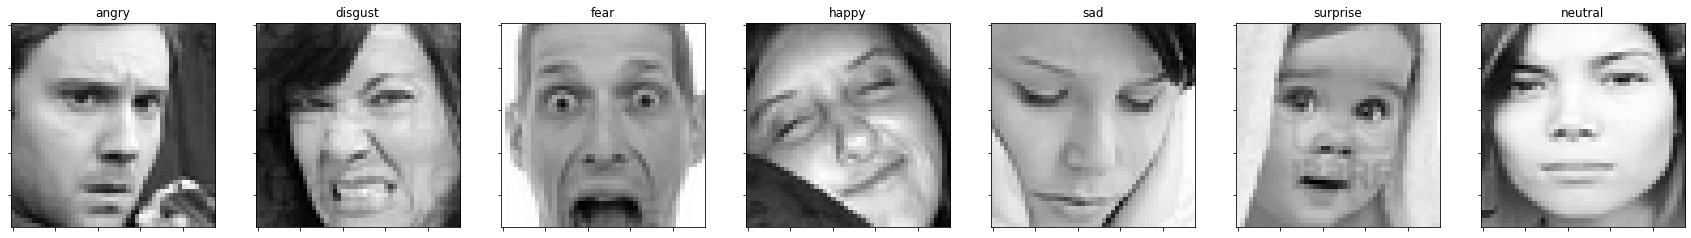

In [53]:
plot_all_emotions()

<p style='font-size:18px'>Angry</p>

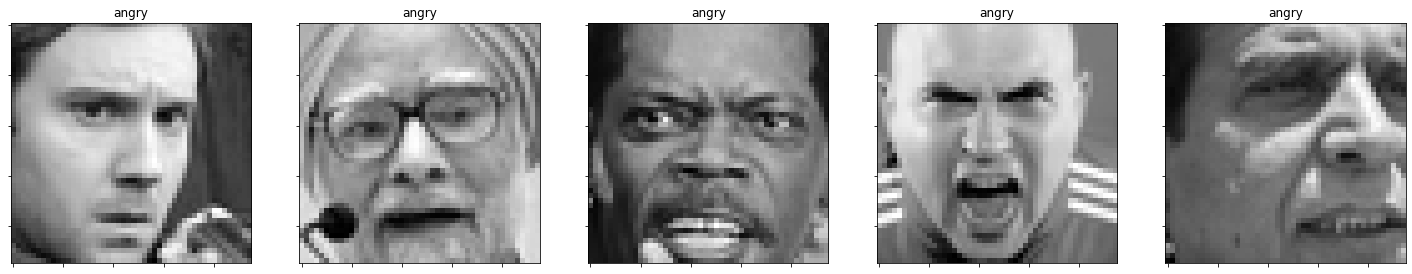

In [54]:
plot_examples(label=0)

<p style='font-size:18px'>Disgust</p>

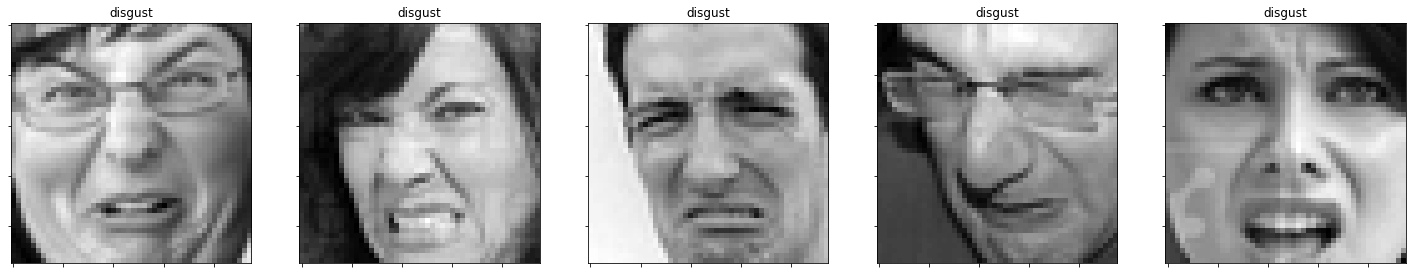

In [55]:
plot_examples(label=1)

<p style='font-size:18px'>Fear</p>

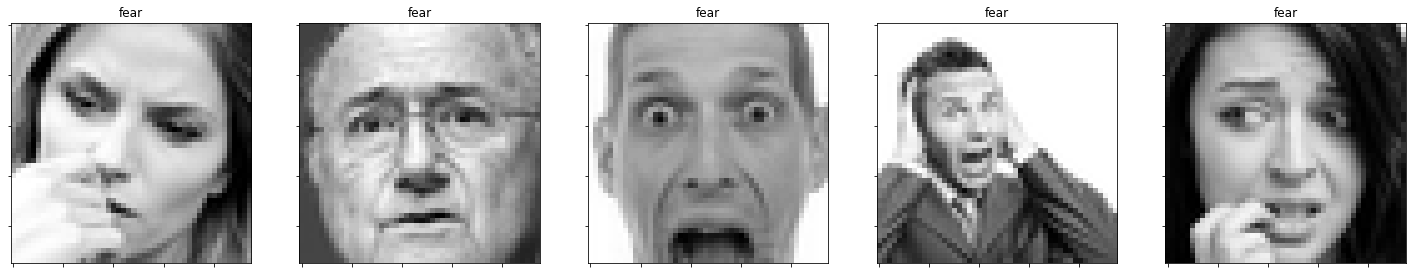

In [56]:
plot_examples(label=2)

<p style='font-size:18px'>Happy</p>

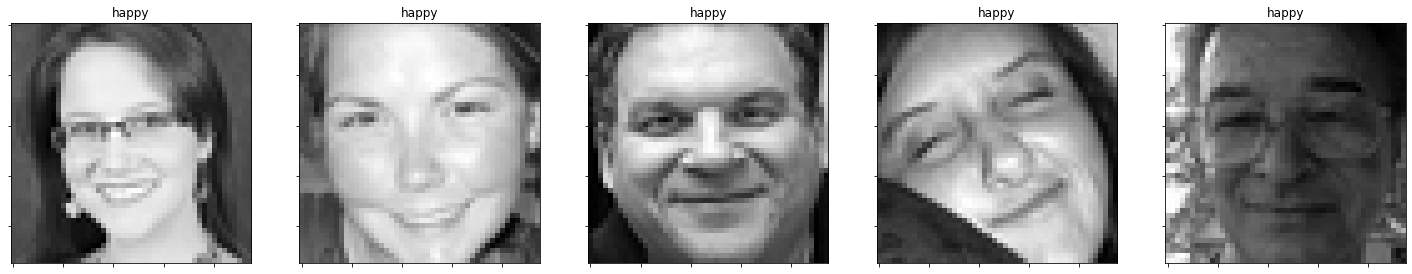

In [57]:
plot_examples(label=3)

<p style='font-size:18px'>Sad</p>

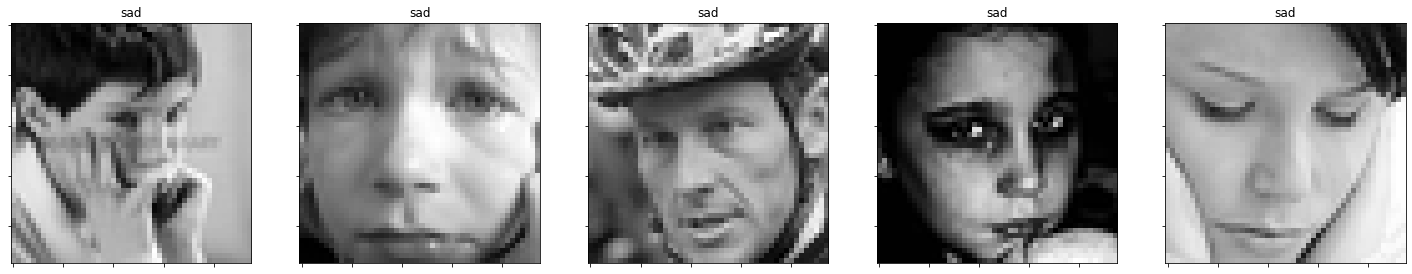

In [58]:
plot_examples(label=4)

<p style='font-size:18px'>Surprise</p>

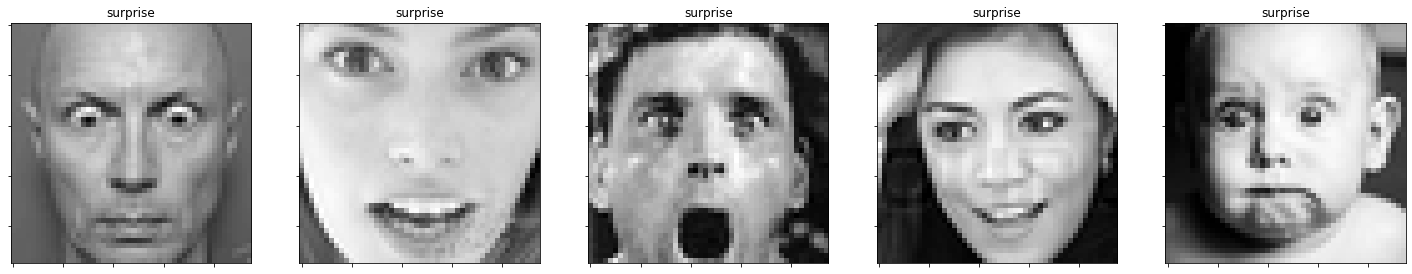

In [59]:
plot_examples(label=5)

<p style='font-size:18px'>Neutral</p>

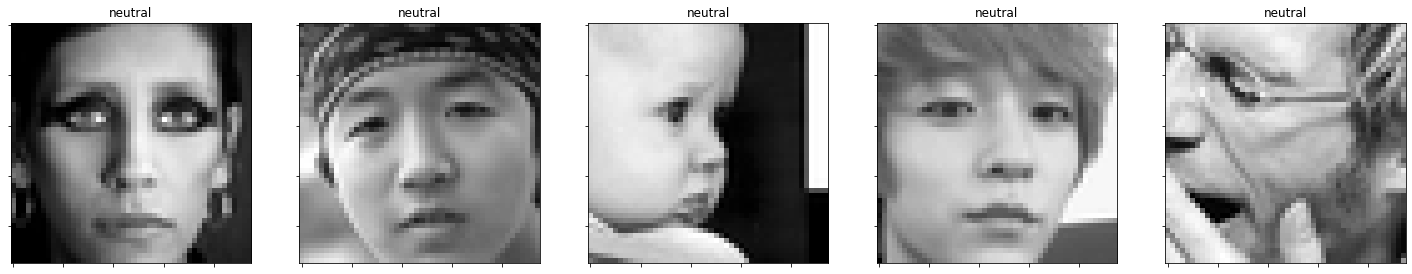

In [60]:
plot_examples(label=6)

# Distribution Of Labels

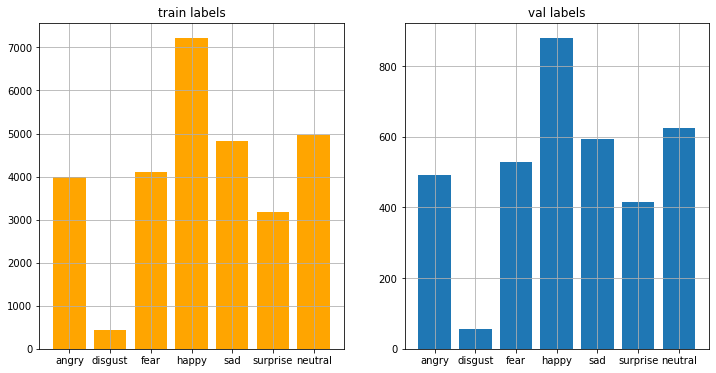

In [61]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

# Class Weights 
<p style='font-size:18px'>Calculate the class weights of the label distribution</p>

In [64]:
class_weight = dict(zip(range(0, 7), (((data[data['usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

# Model
<p style='font-size:18px'>Simple CNN model</p>

In [65]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [66]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

<p style='font-size:20px'>Training the model</p>

In [69]:
history = model.fit(
    train_images, 
    train_labels,
    validation_data=(val_images, val_labels),
    class_weight = class_weight,
    epochs=10,
    batch_size=64
)

Epoch 1/10
449/449 [==============================] - 61s 121ms/step - loss: 0.2857 - accuracy: 0.2656 - val_loss: 1.6354 - val_accuracy: 0.3814
Epoch 2/10
449/449 [==============================] - 51s 113ms/step - loss: 0.2330 - accuracy: 0.4189 - val_loss: 1.5013 - val_accuracy: 0.4439
Epoch 3/10
449/449 [==============================] - 56s 124ms/step - loss: 0.2103 - accuracy: 0.4800 - val_loss: 1.3644 - val_accuracy: 0.4862
Epoch 4/10
449/449 [==============================] - 50s 112ms/step - loss: 0.1969 - accuracy: 0.5160 - val_loss: 1.3262 - val_accuracy: 0.5007
Epoch 5/10
449/449 [==============================] - 53s 117ms/step - loss: 0.1866 - accuracy: 0.5436 - val_loss: 1.3003 - val_accuracy: 0.5107
Epoch 6/10
449/449 [==============================] - 51s 115ms/step - loss: 0.1756 - accuracy: 0.5657 - val_loss: 1.2590 - val_accuracy: 0.5316
Epoch 7/10
449/449 [==============================] - 51s 113ms/step - loss: 0.1704 - accuracy: 0.5872 - val_loss: 1.2667 - val_ac

<p style='font-size:18px'>Test Accuracy</p>

In [83]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_acc*100}%')

113/113 [==============================] - 2s 14ms/step - loss: 1.3074 - accuracy: 0.5364
Test Accuracy: 53.636109828948975%


<p style='font-size:18px'>Predicted Test labels</p>

In [72]:
pred_test_labels = model.predict(test_images)

# Analyse Convergence

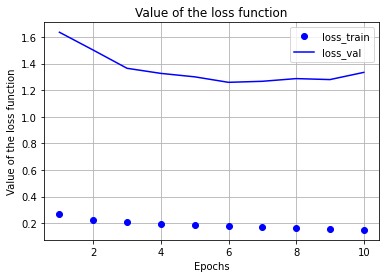

In [73]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('Value of the loss function')
plt.xlabel('Epochs')
plt.ylabel('Value of the loss function')
plt.legend()
plt.grid()
plt.show()

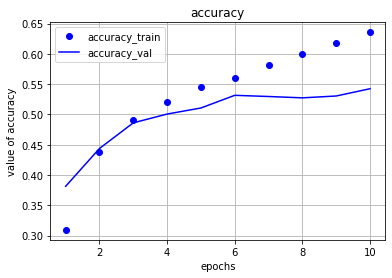

In [74]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

# Analyse Results

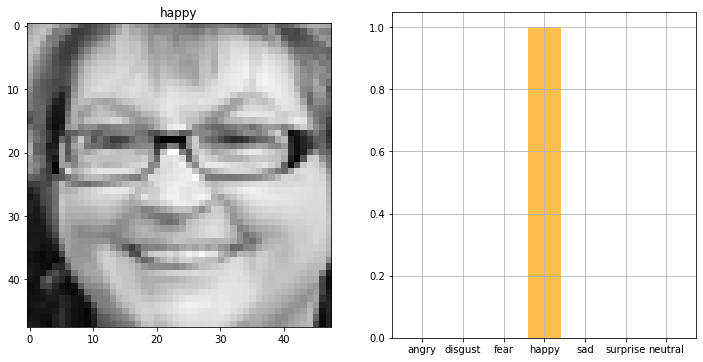

In [76]:
plot_image_and_emotion(test_img, test_img_label, pred_test_labels, 100)

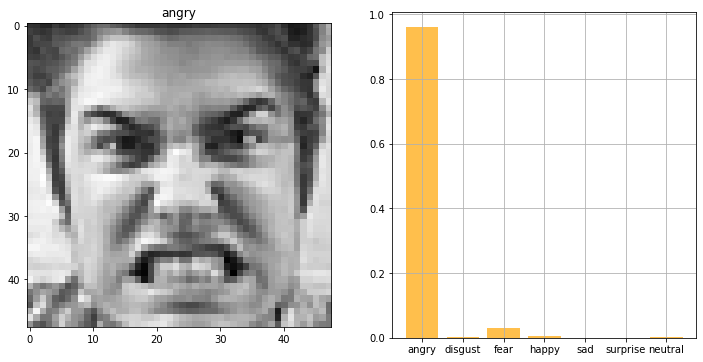

In [77]:
plot_image_and_emotion(test_img, test_img_label, pred_test_labels, 40)

<p style='font-size:18px'>Comparing Acctual test labels and Predicted labesl</p>

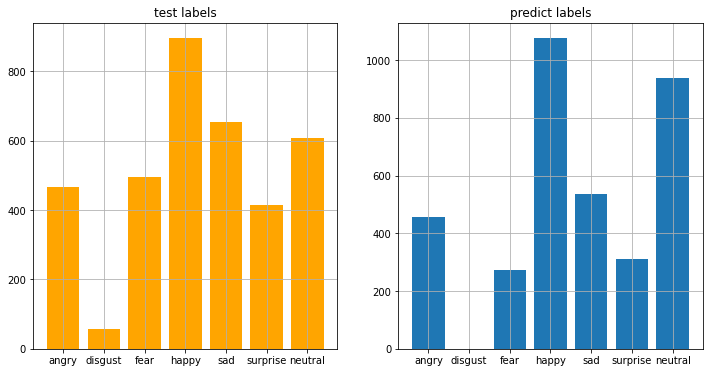

In [80]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

# Analyse Wrong Prediction
<p style='font-size:18px'>The accuracy score is about 54% on the test set. So it is obvious to take focus on the wrong predictions. We want to extract details to improve the model.</p>

In [81]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

<p style='font-size:20px'>Confusion Matrix</p>

/home/dilip/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


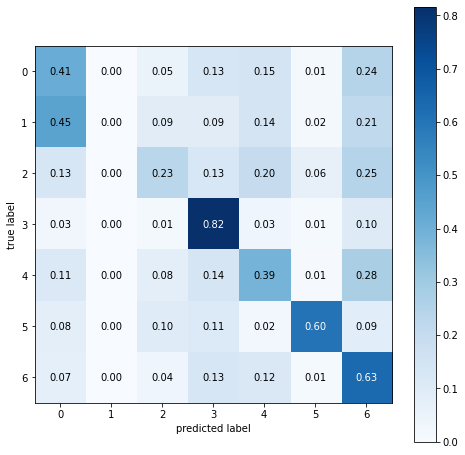

In [82]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

classes = list(emotions.values())

fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat,
    colorbar=True,
    show_absolute=False,
    show_normed=True,
    # class_names=classes,
    figsize=(8, 8)
)

fig.show()